# DS 7333 - Quantifying the World
## Case Study #3

Sterling Beason, Sean Kennedy, Emil Ramos

### Introduction

When scrolling through your personal email, it is easy to identify spam mail from a quick glance at the subject line and sender. Although it is not easy to constantly scroll through your email and delete multiple spam mail in a timely manner. So how do we design an automated procedure to classify and eliminate these unwanted messages when scrolling through your inbox?

In order to identify a solution, part of the decision is based on a statistical analysis of the email message that have been hand classified as spam (unwanted mail) or ham (wanted mail). In this case study, we examine the Spam Assassin dataset (http://spamassassin.apache.org) in which we evaluate 9000 emails with spam filters by using a **DecisionTreeClassifier**, a machine learning algorithm which uses recursive partitioning. **SciKit-Learn's** implementation of the algorithm requires the email messages to be transformed into a form conducive to statisitcal analysis. To organize and quantify this information, we can derive variables from characteristics of the messages and use these to classify email. We use a desicion tree that uses derived variables that represent the characteristics of a message, to classify the messages.

### Objective

Using the “emailDFrp” dataset:

1. Build and evaluate a tree-based model for predicting “spam”
2. Plot and analyze the paths through one (or many) of your trees
3. Explain the parameters involved in “tuning” your model
4. Identify which variables were “most” important
5. Explain how to evaluate the “performance” of your model

In [1]:
import pandas as pd
from IPython.display import SVG

# IMPORTANT: install rpy2 v3.3.x
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score
from sklearn.pipeline import Pipeline

# Recommended Installation: 'conda install python-graphviz' (should add 'graphviz' to PATH)
from graphviz import Source
import seaborn as sns

### Import R Data and Convert to Pandas DataFrame

In [2]:
base = importr('base')
base.load("./Data/data.Rda")
rdf_List = base.mget(base.ls())

with localconverter(ro.default_converter + pandas2ri.converter):
    df = ro.conversion.rpy2py(rdf_List[0]) # convert 'emailDFrp' dataset
    
df = df.reset_index()
df = df.drop('index', 1)

df

,isSpam,isRe,underscore,priority,isInReplyTo,sortedRec,subPunc,multipartText,hasImages,isPGPsigned,...,subQuesCt,numAtt,numRec,perCaps,hour,perHTML,subBlanks,forwards,avgWordLen,numDlr
0,F,T,F,F,T,T,F,F,F,F,...,0,0.0,2,4.451039,11.0,0.000000,12.500000,0.000000,4.376623,3
1,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.491289,11.0,0.000000,8.000000,0.000000,4.555556,0
2,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.436096,12.0,0.000000,8.000000,0.000000,4.817164,0
3,F,F,F,F,F,T,F,F,F,F,...,0,0.0,0,5.090909,13.0,0.000000,18.918919,3.125000,4.714286,0
4,F,T,F,F,F,T,F,F,F,F,...,0,0.0,1,6.116643,13.0,0.000000,15.217391,6.451613,4.234940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9343,T,F,F,F,F,T,F,F,F,F,...,1,0.0,1,8.572552,21.0,79.657111,13.793103,0.000000,4.700555,2
9344,T,F,F,F,F,T,F,T,F,F,...,0,1.0,1,9.436009,23.0,0.000000,10.526316,0.000000,4.904255,4
9345,T,F,F,F,F,F,F,F,F,F,...,0,0.0,1,2.418448,8.0,0.000000,20.000000,0.000000,4.703704,0
9346,T,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.795400,23.0,0.000000,5.263158,0.000000,5.252690,80


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   isSpam         9348 non-null   category
 1   isRe           9348 non-null   category
 2   underscore     9348 non-null   category
 3   priority       9348 non-null   category
 4   isInReplyTo    9348 non-null   category
 5   sortedRec      9348 non-null   category
 6   subPunc        9348 non-null   category
 7   multipartText  9348 non-null   category
 8   hasImages      9348 non-null   category
 9   isPGPsigned    9348 non-null   category
 10  subSpamWords   9341 non-null   category
 11  noHost         9347 non-null   category
 12  numEnd         9348 non-null   category
 13  isYelling      9341 non-null   category
 14  isOrigMsg      9348 non-null   category
 15  isDear         9348 non-null   category
 16  isWrote        9348 non-null   category
 17  numLines       9348 non-null   in

### Data Dictionary

| Variable | Type | Description |
| - | - | - |
| isRe | logical | TRUE ifRe:appears at the start of the subject. | 
| numLines | integer | Number of lines in the body of the message. | 
| bodyCharCt | integer | Number of characters in the body of the message. | 
| underscore | logical | TRUE if email address in theFromfield of the headercontains an underscore. | 
| subExcCt | integer | Number of exclamation marks in the subject. | 
| subQuesCt | integer | Number of question marks in the subject. | 
| numAtt | integer | Number of attachments in the message. | 
| priority | logical | TRUE if aPrioritykey is present in the header. | 
| numRec | numeric | Number of recipients of the message, including CCs. | 
| perCaps | numeric | Percentage of capitals among all letters in the messagebody, excluding attachments. | 
| isInReplyTo | logical | TRUE if theIn-Reply-Tokey is present in the header. | 
| sortedRec | logical | TRUE if the recipients’ email addresses are sorted. | 
| subPunc | logical | TRUE if words in the subject have punctuation or num-bers embedded in them, e.g.,w!se. | 
| hour | numeric | Hour of the day in theDatefield. | 
| multipartText | logical | TRUE if the MIME type is multipart/text. | 
| hasImages | logical | TRUE if the message contains images. | 
| isPGPsigned | logical | TRUE if the message contains a PGP signature. | 
| perHTML | numeric | Percentage of characters inHTMLtags in the messagebody in comparison to all characters. | 
| subSpamWords | logical | TRUE if the subject contains one of the words in a spamword vector. | 
| subBlanks | numeric | Percentage of blanks in the subject. | 
| noHost | logical | TRUE if there is no hostname in theMessage-Idkey inthe header. | 
| numEnd | logical | TRUE if the email sender’s address (before the @) endsin a number. | 
| isYelling | logical | TRUE if the subject is all capital letters. | 
| forwards | numeric | Number of forward symbols in a line of the body, e.g.,>>> xxxcontains 3 forwards. | 
| isOrigMsg | logical | TRUE if the message body contains the phraseoriginalmessage. | 
| isDear | logical | TRUE if the message body contains the worddear. | 
| isWrote | logical | TRUE if the message contains the phrasewrote:. | 
| avgWordLen | numeric | The average length of the words in a message. | 
| numDlr | numeric | Number of dollar signs in the message body. | 

Converting the **hour** field to categorical since the number of possible values (24) is far less than our number of observations.

In [4]:
df.hour = df.hour.astype('category')

In [5]:
df.columns[df.isna().any() == True]

Index(['subSpamWords', 'noHost', 'isYelling', 'subBlanks'], dtype='object')

###  N/A Impution

There are 4 columns with NAs: 

- subSpamWords (category)

- noHost (category)

- isYelling (category)

- subBlanks (float)

Let's analyze the categorical variables first:

***subSpamWords*** - True if the subject contains one of the words in a spamword vector


In [6]:
df.subSpamWords.unique()

[F, T, NaN]
Categories (2, object): [F, T]

[Text(0, 0, '0'),
 Text(0, 0, '1,000'),
 Text(0, 0, '2,000'),
 Text(0, 0, '3,000'),
 Text(0, 0, '4,000'),
 Text(0, 0, '5,000'),
 Text(0, 0, '6,000'),
 Text(0, 0, '7,000'),
 Text(0, 0, '8,000')]

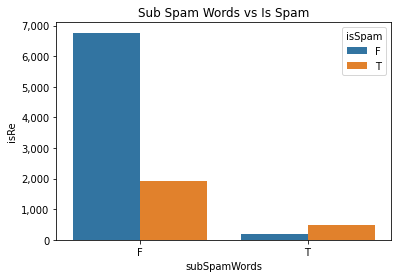

In [7]:
spam_na = df[df.subSpamWords.isna()]
group_by_spam = df.groupby(['subSpamWords', 'isSpam']).count().reset_index()
p1 = sns.barplot(data = group_by_spam, x='subSpamWords', y='isRe', hue='isSpam')
p1.set_title('Sub Spam Words vs Is Spam')
y_ticklabels = [f'{y:,.0f}' for y in p1.get_yticks()]
p1.set_yticklabels(y_ticklabels)

This is just a boolean parameter, let's check the frequency distribution.

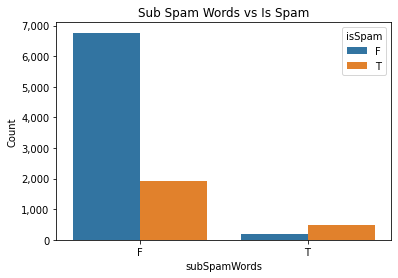

In [8]:
spam_na = df[df.subSpamWords.isna()]
group_by_spam = df.groupby(['subSpamWords', 'isSpam']).count().reset_index().rename(columns={'isRe':'Count'})
p1 = sns.barplot(data = group_by_spam, x='subSpamWords', y='Count', hue='isSpam')
p1.set_title('Sub Spam Words vs Is Spam')
p1.set_yticklabels([f'{y:,.0f}' for y in p1.get_yticks()])
p1

In [9]:
group_by_spam.groupby(['subSpamWords', 'isSpam'])['Count'].sum()

subSpamWords  isSpam
F             F         6768
              T         1929
T             F          176
              T          468
Name: Count, dtype: int64

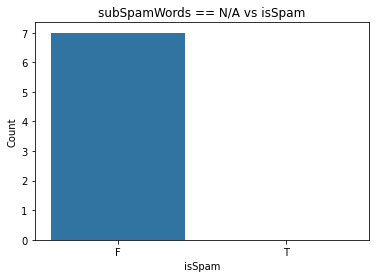

In [10]:
p2 = sns.barplot(data = spam_na.groupby(['isSpam']).count().reset_index().rename(columns={'isRe':'Count'}), x='isSpam', y='Count')
p2.set_title('subSpamWords == N/A vs isSpam')
y_ticklabels = [f'{y:,.0f}' for y in p2.get_yticks()]
p2.set_yticklabels(y_ticklabels)
p2

In [11]:
spam_na.groupby(['isSpam'])['isRe'].count()

isSpam
F    7
T    0
Name: isRe, dtype: int64

From the above, we can see that the ratio of non-spam emails vs. spam emails is higher when **subSpamWords** is False It is the opposite for the case where **subSpamWords** is True. Intuitively, this makes sense, this field indicates the presence of a spam word in the subject line - hence it should be a positive predictor for **isSpam**. Since each of these emails have been classified as not spam, we can safely assume that these are most likely should be imputed to our **False** class for **subSpamWords**. There are 7 observations for this particular field being N/A, so the effect overall of any imputation is likely minimal, at best.

In [12]:
imputed_df = df.copy()
imputed_df.loc[spam_na.index, 'subSpamWords'] = 'F'
assert imputed_df[imputed_df.subSpamWords.isna()].shape[0] == 0

The next field to check N/As for is:

***noHost*** - True if there is no hostname in theMessage-Idkey inthe header.

In [13]:
df.noHost.unique()

[F, T, NaN]
Categories (2, object): [F, T]

Again, this is just a boolean parameter, let's check the frequency distribution.


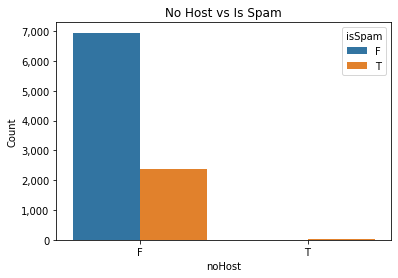

In [14]:
host_na = df[df.noHost.isna()]
group_by_host = df.groupby(['noHost', 'isSpam']).count().reset_index().rename(columns={'isRe':'Count'})
p1 = sns.barplot(data = group_by_host, x='noHost', y='Count', hue='isSpam')
p1.set_title('No Host vs Is Spam')
p1.set_yticklabels([f'{y:,.0f}' for y in p1.get_yticks()])
p1


In [15]:
group_by_host.groupby(['noHost', 'isSpam'])['Count'].sum()

noHost  isSpam
F       F         6951.0
        T         2367.0
T       F            0.0
        T           29.0
Name: Count, dtype: float64

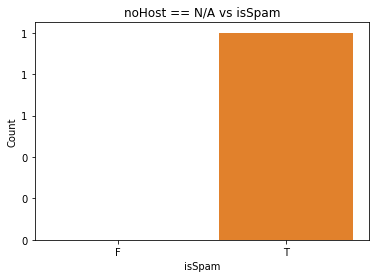

In [16]:
p2 = sns.barplot(data = host_na.groupby(['isSpam']).count().reset_index().rename(columns={'isRe':'Count'}), x='isSpam', y='Count')
p2.set_title('noHost == N/A vs isSpam')
y_ticklabels = [f'{y:,.0f}' for y in p2.get_yticks()]
p2.set_yticklabels(y_ticklabels)
p2

In [17]:
host_na.groupby(['isSpam'])['isRe'].count()

isSpam
F    0
T    1
Name: isRe, dtype: int64

In this case, the **noHost** field only has one N/A, so its impact is negligable - given the observed distribution of this field (strongly tilted towards the **False** class) - it's highly unlikely that this field would e false to begin with, regardless of its classification as spam or not. Hence, we'll impute this value to **False**. 

In [18]:
imputed_df.loc[host_na.index, 'noHost'] = 'F'
assert imputed_df[imputed_df.noHost.isna()].shape[0] == 0

The next field to check N/As for is:

***isYelling*** - True if the subject is all capital letters

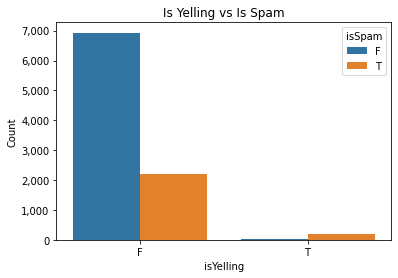

In [19]:
yelling_na = df[df.isYelling.isna()]
group_by_yelling = df.groupby(['isYelling', 'isSpam']).count().reset_index().rename(columns={'isRe':'Count'})
p1 = sns.barplot(data = group_by_yelling, x='isYelling', y='Count', hue='isSpam')
p1.set_title('Is Yelling vs Is Spam')
p1.set_yticklabels([f'{y:,.0f}' for y in p1.get_yticks()])
p1


In [20]:
group_by_yelling.groupby(['isYelling', 'isSpam'])['Count'].sum()

isYelling  isSpam
F          F         6931
           T         2203
T          F           13
           T          194
Name: Count, dtype: int64

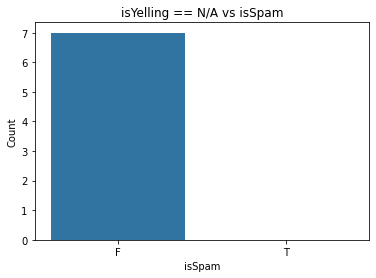

In [21]:
p2 = sns.barplot(data = yelling_na.groupby(['isSpam']).count().reset_index().rename(columns={'isRe':'Count'}), x='isSpam', y='Count')
p2.set_title('isYelling == N/A vs isSpam')
y_ticklabels = [f'{y:,.0f}' for y in p2.get_yticks()]
p2.set_yticklabels(y_ticklabels)
p2

In [22]:
yelling_na.groupby(['isSpam'])['isRe'].count()

isSpam
F    7
T    0
Name: isRe, dtype: int64

From the above, we can see that the ratio of non-spam emails vs. spam emails is higher when **isYelling** is False. It is the opposite for the case where **isYelling** is True, nearly all of those observations were spam emails (194/207). Since each of these emails have been classified as not spam, we can safely assume that these should be imputed to our **False** class for **isYelling**. There are 7 observations for this particular field being N/A, so the effect overall of any imputation is likely minimal, at best.


In [23]:
imputed_df.loc[yelling_na.index, 'isYelling'] = 'F'
assert imputed_df[imputed_df.isYelling.isna()].shape[0] == 0

The next field to check N/As for is:

***subBlanks*** - Percentage of blanks in the subject.

We'll handle this slightly differently than other fields since it's a float, not a categorical.

In [24]:
df[df.subBlanks.isna()].groupby(['isSpam'])[['isRe']].count().rename(columns={'isRe':'Count'})

,Count
isSpam,
F,7
T,13


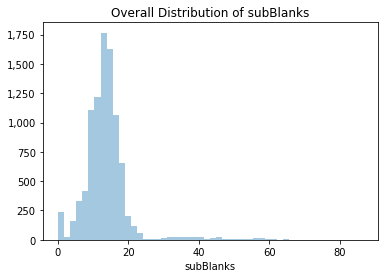

In [25]:
not_na = df[~df.subBlanks.isna()]['subBlanks']
p = sns.distplot(not_na, kde=False)
p.set_title('Overall Distribution of subBlanks')
y_ticklabels = [f'{y:,.0f}' for y in p.get_yticks()]
p.set_yticklabels(y_ticklabels)
p

In [26]:
print(not_na.describe())
print(f'Median = {round(not_na.median(), 4)}')

count    9328.000000
mean       13.866939
std         7.431938
min         0.000000
25%        10.526316
50%        13.253012
75%        15.686275
max        86.419753
Name: subBlanks, dtype: float64
Median = 13.253


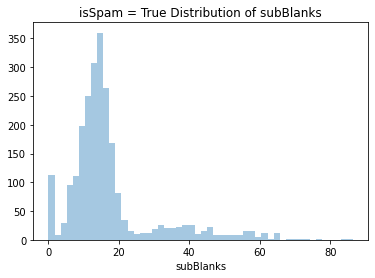

In [27]:
true_na = df[(~df.subBlanks.isna())
& (df.isSpam == 'T')
]['subBlanks']

p = sns.distplot(true_na, kde=False)
p.set_title('isSpam = True Distribution of subBlanks')
y_ticklabels = [f'{y:,.0f}' for y in p.get_yticks()]
p.set_yticklabels(y_ticklabels)
p

In [28]:
print(true_na.describe())
print(round(true_na.median(),4))

count    2384.000000
mean       17.078511
std        12.584919
min         0.000000
25%        10.526316
50%        14.285714
75%        17.777778
max        86.419753
Name: subBlanks, dtype: float64
14.2857


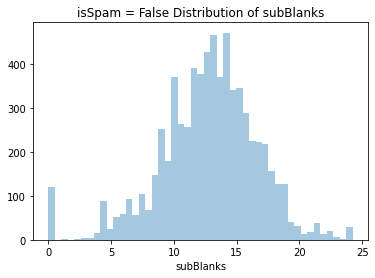

In [29]:
false_na = df[(~df.subBlanks.isna())
& (df.isSpam == 'F')
]['subBlanks']

p = sns.distplot(false_na, kde=False)
p.set_title('isSpam = False Distribution of subBlanks')
y_ticklabels = [f'{y:,.0f}' for y in p.get_yticks()]
p.set_yticklabels(y_ticklabels)
p

In [30]:
print(false_na.describe())
print(round(false_na.median(), 4))

count    6944.000000
mean       12.764349
std         3.883546
min         0.000000
25%        10.416667
50%        13.043478
75%        15.384615
max        24.242424
Name: subBlanks, dtype: float64
13.0435


In this case we see an interesting situation, **subBlanks** for the True/False class (**isSpam**) appear to have very different distributions - skewed highly towards higher numbers for our True class, far more normal for our False class. 

For our N/A data, **65%** (13/20) of our observations **are spam** - assigning them values from the overall distribution (whether using the mean or median) could be problematic. We'll opt for an imputation scheme where we impute our True labeled N/As to the **mean** of observations that have been observed as spam and observations where our label is False to the **mean** of observations that are not spam.

In the wild, we will not have the option of knowing beforehand whether or not a message is spam, so we will opt to impute N/As for this field to the **mean** of our training set (after applying the impution scheme described above).

### Data Partitioning

We will use an 80/20 train test split for our data (80% train/test - 20% validation)

For our **GridSearchCV**, we will perform a 5 fold **StratifiedShuffleSplit** for model tuning/selection.

In [31]:
#df = df.dropna() # TODO: Impute NAs, don't drop them

features = imputed_df[imputed_df.columns.difference(['isSpam'])].copy()


X = pd.get_dummies(features, drop_first=True)
y = imputed_df['isSpam'].astype('object').apply(lambda x: 1 if x == 'T' else 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7333)

Let's make our imputions for **subBlanks** now that we have a train test split:

In [32]:
true_impute = X_train.loc[y_train[y_train == 1].index, 'subBlanks'].mean()
false_impute = X_train.loc[y_train[y_train == 0].index, 'subBlanks'].mean()

In [33]:
true_impute, false_impute

(17.10061458260949, 12.7628082250653)

In [34]:
X_train.loc[X_train[(X_train.index.isin(y_train[y_train==1].index))
        & (X_train.subBlanks.isna())].index, ['subBlanks']] = true_impute

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [35]:
X_train.loc[X_train[(X_train.index.isin(y_train[y_train==0].index))
        & (X_train.subBlanks.isna())].index, ['subBlanks']] = false_impute

In [36]:
X_test.loc[X_test[(X_test.index.isin(y_test[y_test==1].index))
        & (X_test.subBlanks.isna())].index, ['subBlanks']] = true_impute

In [37]:
X_test.loc[X_test[(X_test.index.isin(y_test[y_test==0].index))
        & (X_test.subBlanks.isna())].index, ['subBlanks']] = false_impute

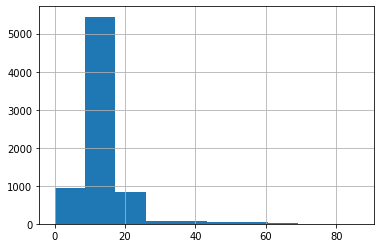

In [38]:
X_train['subBlanks'].hist()

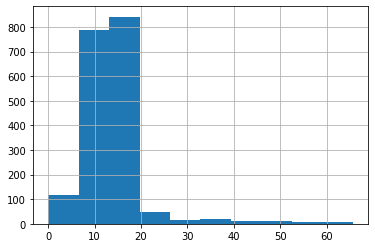

In [39]:
X_test['subBlanks'].hist()

Distributions for our imputed variable look reasonable in both our train and test sets. Distributions should match as closely as possible.

In [40]:
X_test[X_test.subBlanks.isna()]

,avgWordLen,bodyCharCt,forwards,numAtt,numDlr,numLines,numRec,perCaps,perHTML,subBlanks,...,isWrote_T,isYelling_T,multipartText_T,noHost_T,numEnd_T,priority_T,sortedRec_T,subPunc_T,subSpamWords_T,underscore_T


In [41]:
X_train[X_train.subBlanks.isna()]

,avgWordLen,bodyCharCt,forwards,numAtt,numDlr,numLines,numRec,perCaps,perHTML,subBlanks,...,isWrote_T,isYelling_T,multipartText_T,noHost_T,numEnd_T,priority_T,sortedRec_T,subPunc_T,subSpamWords_T,underscore_T


### Modeling - Decision Tree

For tuning purposes, we'll try to beat the baseline scikit leark **DecisionTreeClassifier**

In [42]:
clf = DecisionTreeClassifier(random_state=7333)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

# Accuracy
accuracy_score(y_test, pred)

0.9668449197860962

In [43]:
clf.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'random_state': 7333,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': 'deprecated',
 'ccp_alpha': 0.0,
 'n_features_': 51,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 51,
 'tree_': <sklearn.tree._tree.Tree at 0x7fea9ce2ea58>}

### Cross Validation

5-fold 80/20 stratified shuffle split

In [44]:
n_splits = 5
cv = StratifiedShuffleSplit(n_splits,test_size=.2, train_size=.8, random_state=7333)

### Tuneable Parameters

Using the below options for hyper-parameter tuning, we will seek to improve on our baseline classifier.

In [45]:
criteria = ['gini', 'entropy'] # define possible splitting criteria
splitters = ['best', 'random'] 
max_depth = list(range(20, 50, 5))
min_samples_split = list(range(3, 5, 1))
min_samples_leaf = list(range(2, 5, 1))
max_features = ['auto', 'sqrt', 'log2']
random_state = 7333
max_leaf_nodes = list(range(5, 20, 3))
scoring = {
           # 'Accuracy':'accuracy'
           # , 'F-1 Score':'f1'
           # , 'AUC':'roc_auc'
             'Precision':'precision'
}

### Model Tuning

General grid search with **precision** as our chosen metric for cross validation.

We selected precision as our scoring metric to evaluate the performance of our model because it highlights how precise/accurate our model by adding combining the true positive and false positive to get a total predicted positive score. It is also a good measure to determine when the costs of false positive is high. In our case study, a false positive means that an email that is ham (actual negative) has been identified as spam (predicted spam). The precision score for our spam detection model must be high to prevent the loss of important emails. Our goal is to minimize the amount of false positives, and false negatives within the resulting confusion matrix.

The first parameter we will tune in our decision tree is the node splitting criterion, **entropy** or **gini** (default).

By definition (credit to Dr. Drew's laTex):

$$Gini=\sum_{t=1}^T \frac{n_t}{N}gini(t)$$
where $T$ is the total number of splits (2 for binary attributes), $n_t$ is the number of instances in node $t$ after splitting, and $N$ is the total number of instances in the parent node. $gini(t)$ is the **gini index for each individual node that is created by the split** and is given by:
$$gini(t)=1-\sum_{j=0}^{C-1} p(j|t)^2$$
where $C$ is the total number of possible classes and $p(j|t)$ is the probability of class $j$ in node $t$ (i.e., $n_j==$ the count of instances belonging to class $j$ in node $t$, normalized by the total number of instances in node $t$).

$$ p(j|t) = \frac{n_j}{n_t}$$ 


$$ Entropy(t) = -\sum p(j|t) \log p(j|t) $$
where $p(j|t)$ is the same as above. To combine Entropy measures from a set of nodes, t = {1,...,T} we use: 
$$Entropy_{split}=\sum_{t=1}^T \frac{n_t}{N}Entropy(t)$$ 
where $n_t$ and $N$ are the same as defined above for the $Gini$. Information gain is calculated by subtracting the Entropy of the split from the Entropy of the parent node before splitting:
$$InfoGain = Entropy(p)-Entropy_{split}$$

where $p$ is the parent node before splitting 



In [46]:
pipe = Pipeline(steps=[('decision_tree', clf)])
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 #'decision_tree__criterion':criteria,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Precision score of best estimator: 0.9284253578732107


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [47]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [48]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).reset_index(drop=True).T
print(sorted_results[0].params)
sorted_results

{'decision_tree__criterion': 'entropy'}


,0,1
split0_test_Precision,0.917738,0.928
split1_test_Precision,0.9375,0.916667
split2_test_Precision,0.925926,0.935933
split3_test_Precision,0.941504,0.922872
split4_test_Precision,0.924528,0.927027
mean_test_Precision,0.929439,0.9261
std_test_Precision,0.00876268,0.00633349
rank_test_Precision,1,2
params,{'decision_tree__criterion': 'entropy'},{'decision_tree__criterion': 'gini'}


**Entropy** appears slightly better with a mean precision score at 0.929 given that this precision is worse than baseline. We should continue our search and consider opting for **gini** if further tuning prefers it, since entropy might be a slightly slower to compute.

Let's try tuning our splitting logic - according to the sklearn docs:

**splitter{“best”, “random”}, default=”best”**

The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

In [49]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Precision score of best estimator: 0.9284253578732107


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


In [50]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [51]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).reset_index(drop=True).T
print(sorted_results[0].params)
sorted_results

{'decision_tree__criterion': 'entropy', 'decision_tree__splitter': 'best'}


,0,1,2,3
split0_test_Precision,0.917738,0.93733,0.928,0.922043
split1_test_Precision,0.9375,0.95935,0.916667,0.92126
split2_test_Precision,0.925926,0.909326,0.935933,0.930295
split3_test_Precision,0.941504,0.913514,0.922872,0.911602
split4_test_Precision,0.924528,0.915301,0.927027,0.920981
mean_test_Precision,0.929439,0.926964,0.9261,0.921236
std_test_Precision,0.00876268,0.0188908,0.00633349,0.00592605
rank_test_Precision,1,2,3,4
params,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis..."


Still sticking with **entropy** and **best** as our chosen params, but still no significant improvement on precision.

In order to keep our tree simple and not overfit, we should limit our depth.

From sklearn docs:

**max_depth int, default=None**

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [52]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s


Precision score of best estimator: 0.9278350515463918


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished


In [53]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=25,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [54]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).reset_index(drop=True).T
print(sorted_results[0].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 25, 'decision_tree__splitter': 'random'}


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
split0_test_Precision,0.951149,0.970238,0.938375,0.946023,0.949296,0.92562,0.926829,0.927461,0.93634,0.940701,...,0.917738,0.937669,0.914948,0.93733,0.917738,0.928,0.928,0.922043,0.926121,0.922043
split1_test_Precision,0.96034,0.946023,0.948127,0.961219,0.944928,0.96,0.936464,0.950549,0.948424,0.949333,...,0.9375,0.945355,0.942779,0.95935,0.9375,0.916667,0.916667,0.945055,0.95082,0.933511
split2_test_Precision,0.944134,0.920548,0.943343,0.932432,0.941176,0.953216,0.948864,0.921053,0.927807,0.934247,...,0.925926,0.919137,0.916449,0.915989,0.925926,0.935933,0.935933,0.930295,0.930295,0.930295
split3_test_Precision,0.946746,0.946108,0.950413,0.95,0.928775,0.910082,0.942623,0.93733,0.929775,0.922438,...,0.941504,0.916216,0.936813,0.913514,0.934426,0.922872,0.922872,0.911602,0.897098,0.911602
split4_test_Precision,0.953757,0.944444,0.935393,0.925208,0.935211,0.950437,0.933518,0.945205,0.933518,0.927374,...,0.924528,0.928767,0.931129,0.915301,0.924528,0.927027,0.927027,0.920981,0.922872,0.920981
mean_test_Precision,0.951225,0.945472,0.94313,0.942976,0.939877,0.939871,0.93766,0.93632,0.935173,0.934819,...,0.929439,0.929429,0.928424,0.928297,0.928024,0.9261,0.9261,0.925995,0.925441,0.923686
std_test_Precision,0.00565414,0.0157247,0.00566608,0.0127929,0.00722406,0.0188967,0.00756364,0.0108997,0.00725364,0.00953216,...,0.00876268,0.0109771,0.0110341,0.0178033,0.00711633,0.00633349,0.00633349,0.0112221,0.0171933,0.00769722
rank_test_Precision,1,2,3,4,5,6,7,8,9,10,...,14,16,17,18,19,20,20,22,23,24
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...",...,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis..."


After setting the max_depth = 25, the precision score seems to have a sizeable improvement at 0.95122, let's keep that in mind.

sklearn docs:

**min_samples_split** int or float, default=2

The minimum number of samples required to split an internal node:



In [55]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s


Precision score of best estimator: 0.9221052631578948


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.5s finished


In [56]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=25,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [57]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).reset_index(drop=True).T
print(sorted_results[0].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 25, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'random'}


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
split0_test_Precision,0.929379,0.958702,0.943787,0.941828,0.940341,0.927778,0.94051,0.941667,0.93634,0.922667,...,0.907692,0.907692,0.907692,0.906166,0.91601,0.926431,0.918919,0.939394,0.904509,0.926431
split1_test_Precision,0.970674,0.943182,0.943182,0.937853,0.96988,0.963173,0.952514,0.924581,0.943662,0.939394,...,0.932249,0.932249,0.932249,0.96904,0.911688,0.948571,0.938338,0.948864,0.945799,0.921466
split2_test_Precision,0.941176,0.920765,0.927577,0.942197,0.932615,0.932203,0.928962,0.94051,0.937669,0.940171,...,0.928571,0.928571,0.928571,0.920904,0.935754,0.923077,0.918206,0.915761,0.912467,0.923077
split3_test_Precision,0.948795,0.948012,0.954268,0.947658,0.917808,0.943114,0.939306,0.947222,0.932584,0.950276,...,0.937158,0.937158,0.937158,0.888587,0.9375,0.907104,0.918539,0.90137,0.928375,0.907104
split4_test_Precision,0.944444,0.951952,0.936047,0.932394,0.94,0.931232,0.934097,0.938028,0.938719,0.930939,...,0.923288,0.923288,0.923288,0.936416,0.912,0.905914,0.914601,0.902116,0.914127,0.905914
mean_test_Precision,0.946894,0.944523,0.940972,0.940386,0.940129,0.9395,0.939078,0.938402,0.937795,0.936689,...,0.925792,0.925792,0.925792,0.924223,0.922591,0.922219,0.92172,0.921501,0.921056,0.916798
std_test_Precision,0.0135249,0.0129201,0.008869,0.00507006,0.0169696,0.0129033,0.00787112,0.00753734,0.00359334,0.00931386,...,0.0101241,0.0101241,0.0101241,0.0274381,0.0115749,0.0155386,0.00845163,0.0194054,0.0145697,0.00856083
rank_test_Precision,1,2,3,4,5,6,7,8,9,10,...,39,39,39,42,43,44,45,46,47,48
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...",...,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis..."


After tuning the **min_samples_split** to 3, we have effectively limited our algorithm from splitting on any feature where a split would have less than 3 observations. Note that our value for splitter has also switched to **random** and criterion is now **gini**.

In [58]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.5s


Precision score of best estimator: 0.9372294372294372


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    5.9s finished


In [59]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=35,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [60]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'random'}


,39,37,13,15,1,3,87,85,0,2,...,52,54,64,66,30,28,89,91,107,105
split0_test_Precision,0.96793,0.96793,0.972222,0.972222,0.925926,0.925926,0.947214,0.947214,0.946176,0.946176,...,0.913158,0.913158,0.913158,0.913158,0.893229,0.893229,0.913408,0.913408,0.910364,0.910364
split1_test_Precision,0.941011,0.941011,0.94186,0.94186,0.950437,0.950437,0.942197,0.942197,0.91831,0.91831,...,0.907859,0.907859,0.907859,0.907859,0.914601,0.914601,0.90625,0.90625,0.891738,0.891738
split2_test_Precision,0.923077,0.923077,0.922222,0.922222,0.922438,0.922438,0.942197,0.942197,0.942529,0.942529,...,0.913043,0.913043,0.913043,0.913043,0.911602,0.911602,0.890756,0.890756,0.892857,0.892857
split3_test_Precision,0.933526,0.933526,0.926901,0.926901,0.935103,0.935103,0.939828,0.939828,0.94382,0.94382,...,0.911765,0.911765,0.911765,0.911765,0.914209,0.914209,0.886792,0.886792,0.899441,0.899441
split4_test_Precision,0.930435,0.930435,0.922414,0.922414,0.938776,0.938776,0.89589,0.89589,0.915068,0.915068,...,0.862245,0.862245,0.862245,0.862245,0.866667,0.866667,0.902235,0.902235,0.882682,0.882682
mean_test_Precision,0.939196,0.939196,0.937124,0.937124,0.934536,0.934536,0.933465,0.933465,0.933181,0.933181,...,0.901614,0.901614,0.901614,0.901614,0.900062,0.900062,0.899888,0.899888,0.895416,0.895416
std_test_Precision,0.0154769,0.0154769,0.0189594,0.0189594,0.00991615,0.00991615,0.0189413,0.0189413,0.0135547,0.0135547,...,0.0197781,0.0197781,0.0197781,0.0197781,0.018475,0.018475,0.00983513,0.00983513,0.00918578,0.00918578
rank_test_Precision,1,1,3,3,5,5,7,7,9,9,...,135,135,135,135,139,139,141,141,143,143
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...",...,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis..."


After tuning the **min_samples_leaf** to 2, we have effectively limited our algorithm from creating leaf nodes with anything less than 2 observations.

Let's tune **max_features** just so we can limit the depth and complexity of our tree.

In [61]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 'decision_tree__max_features': max_features
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:    7.9s


Precision score of best estimator: 0.9129511677282378


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:    8.8s finished


In [62]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=20,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [63]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).reset_index(drop=True).T
print(sorted_results[0].params)
sorted_results

{'decision_tree__criterion': 'entropy', 'decision_tree__max_depth': 20, 'decision_tree__max_features': 'auto', 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'best'}


,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
split0_test_Precision,0.916427,0.916427,0.916427,0.916427,0.91716,0.91716,0.91716,0.91716,0.91092,0.91092,...,0.876056,0.876056,0.868493,0.868493,0.868493,0.868493,0.86646,0.86646,0.812849,0.812849
split1_test_Precision,0.911315,0.911315,0.911315,0.911315,0.915942,0.915942,0.915942,0.915942,0.931624,0.931624,...,0.82659,0.82659,0.855153,0.855153,0.855153,0.855153,0.838926,0.838926,0.789894,0.789894
split2_test_Precision,0.932722,0.932722,0.932722,0.932722,0.933908,0.933908,0.933908,0.933908,0.918079,0.918079,...,0.870523,0.870523,0.841808,0.841808,0.841808,0.841808,0.845714,0.845714,0.796791,0.796791
split3_test_Precision,0.915493,0.915493,0.915493,0.915493,0.911932,0.911932,0.911932,0.911932,0.910663,0.910663,...,0.814324,0.814324,0.826667,0.826667,0.826667,0.826667,0.773585,0.773585,0.870317,0.870317
split4_test_Precision,0.899441,0.899441,0.899441,0.899441,0.883784,0.883784,0.883784,0.883784,0.89008,0.89008,...,0.827676,0.827676,0.820312,0.820312,0.820312,0.820312,0.87037,0.87037,0.84573,0.84573
mean_test_Precision,0.91508,0.91508,0.91508,0.91508,0.912545,0.912545,0.912545,0.912545,0.912273,0.912273,...,0.843034,0.843034,0.842487,0.842487,0.842487,0.842487,0.839011,0.839011,0.823116,0.823116
std_test_Precision,0.0106954,0.0106954,0.0106954,0.0106954,0.0162284,0.0162284,0.0162284,0.0162284,0.0134544,0.0134544,...,0.025206,0.025206,0.0177719,0.0177719,0.0177719,0.0177719,0.0348205,0.0348205,0.0304678,0.0304678
rank_test_Precision,1,1,1,1,5,5,5,5,9,9,...,423,423,425,425,425,425,429,429,431,431
params,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...",...,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision..."


Tuning **max_features** didn't have a positive impact on our precision.

Let's limit complexity further by tuning **max_leaf_nodes**

In [64]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 'decision_tree__max_features': max_features,
                                 'decision_tree__max_leaf_nodes': max_leaf_nodes,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:   28.6s


Precision score of best estimator: 0.9796954314720813


[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed:   32.2s finished


In [65]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=20,
                                        max_features='log2', max_leaf_nodes=11,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [66]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).reset_index(drop=True).T
print(sorted_results[0].params)
sorted_results

{'decision_tree__criterion': 'entropy', 'decision_tree__max_depth': 30, 'decision_tree__max_features': 'log2', 'decision_tree__max_leaf_nodes': 11, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 4, 'decision_tree__splitter': 'random'}


,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
split0_test_Precision,0.982036,0.982036,0.982036,0.982036,0.982036,0.982036,0.982036,0.982036,0.982036,0.982036,...,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125
split1_test_Precision,0.986755,0.986755,0.986755,0.986755,0.986755,0.986755,0.986755,0.986755,0.986755,0.986755,...,0.616667,0.616667,0.616667,0.616667,0.616667,0.616667,0.616667,0.616667,0.616667,0.616667
split2_test_Precision,0.992958,0.992958,0.992958,0.992958,0.992958,0.992958,0.992958,0.992958,0.992958,0.992958,...,0.755486,0.755486,0.755486,0.755486,0.755486,0.755486,0.755486,0.755486,0.755486,0.755486
split3_test_Precision,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,0.987179,...,0.706625,0.706625,0.706625,0.706625,0.706625,0.706625,0.706625,0.706625,0.706625,0.706625
split4_test_Precision,0.985075,0.985075,0.985075,0.985075,0.985075,0.985075,0.985075,0.985075,0.985075,0.985075,...,0.604839,0.604839,0.604839,0.604839,0.604839,0.604839,0.604839,0.604839,0.604839,0.604839
mean_test_Precision,0.986801,0.986801,0.986801,0.986801,0.986801,0.986801,0.986801,0.986801,0.986801,0.986801,...,0.682348,0.682348,0.682348,0.682348,0.682348,0.682348,0.682348,0.682348,0.682348,0.682348
std_test_Precision,0.00357035,0.00357035,0.00357035,0.00357035,0.00357035,0.00357035,0.00357035,0.00357035,0.00357035,0.00357035,...,0.06059,0.06059,0.06059,0.06059,0.06059,0.06059,0.06059,0.06059,0.06059,0.06059
rank_test_Precision,1,1,1,1,1,1,1,1,1,1,...,2089,2089,2089,2089,2089,2089,2089,2089,2089,2089
params,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...",...,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision..."


Significant improvements made by limiting our **max_leaf_nodes** to 11. Uut of sample precision 0.9797 is an improvement on our baseline - 0.9668.

Our tuned classifier had the following values:

- criterion: 'entropy'
- max_depth: 30
- max_features: 'log2'
- max_leaf_nodes: 11
- min_samples_leaf: 2
- min_samples_split: 4
- decision_tree__splitter: 'random'

A look at the internals of our chosen classifier:

In [69]:
clf_fit.best_estimator_['decision_tree'].__dict__

{'criterion': 'entropy',
 'splitter': 'random',
 'max_depth': 20,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'log2',
 'random_state': 7333,
 'max_leaf_nodes': 11,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': 'deprecated',
 'ccp_alpha': 0.0,
 'n_features_': 51,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 5,
 'tree_': <sklearn.tree._tree.Tree at 0x7fea9d24d098>}

### Decision Tree

There are 11 leaf nodes in our **DecisionTreeClassifier** 

The **isInReplyTo_T** feature is the most important (i.e led to the largest entropy-based split) which makes sense, given that when an email is marked as a reply to one you have already sent, it's highly unlikely that it would be spam. This feature split classifies 2,245 observations as spam.

Splitting the remaining 5,233 samples on the next feature **isDear_T**, creates a marginal split where we can classify 67 observations as **ham** when the word **dear** appears in the message - not very helpful.

Of the remaining 5,166 unclassified observations, **perHTML** was the next most important splitting feature. When the percent of HTML tags with respect to all text was higher than ~8.7%, then the message was classified as **ham**.

Splitting the remaining 4,269 observations on **hour_8.0** shows that when the hour is less than 8, we were very likely to see a **spam** classification. Also rather intuitiive given that most spam is delivered by bots while you sleep. 

The last split in this part of the tree take place on **subExCt**, another meaningful variable in terms of context given than spam messages are very likely to contain a large number of exclamation points in their subject lines.

The other paths in the tree were not as effective at discriminating **ham** from **spam** though they were not entirely useless given our remarkable precision score. 

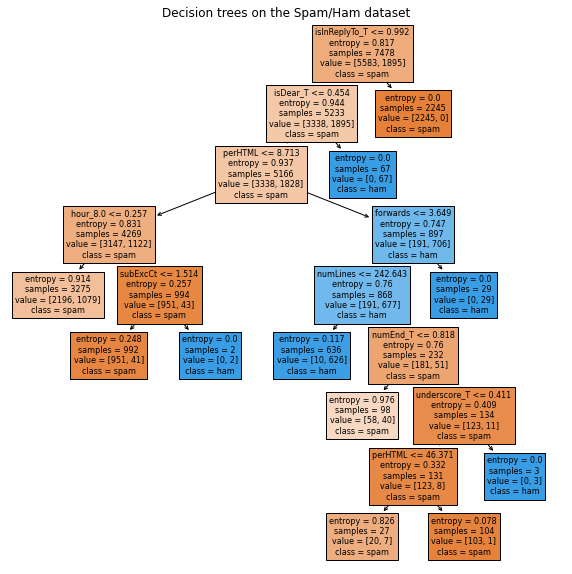

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
tree.plot_tree(clf_fit.best_estimator_['decision_tree']
                   , feature_names=X.columns, class_names=['spam', 'ham'], filled = True)
plt.title("Decision trees on the Spam/Ham dataset")
plt.show()